In [1]:
import matplotlib as mpl 
mpl.use("pgf") 
pgf_with_rc_fonts = {
    "font.serif": [],
}

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['axes.facecolor'] = 'w'

In [2]:
def correctColors(ax, new_colors, remove_blacks=True):
    assert len(new_colors) > 0
    randomIndex = 0
    for line in ax.get_lines():
        if line.get_color() == 'black' and remove_blacks:
            #line.set_color([0.9, 0.9, 0.9])
            line.remove()
        else:
            line.set_color(new_colors[randomIndex])
            randomIndex = (randomIndex + 1) % len(new_colors)

# http://stackoverflow.com/questions/7358118/matplotlib-black-white-colormap-with-dashes-dots-etc
def setAxLinesBW(ax, bw=True):
    """
    Take each Line2D in the axes, ax, and convert the line style to be 
    suitable for black and white viewing.
    """
    MARKERSIZE = 3
    COLORMAP = {
        'b': {'marker': None, 'dash': (None,None)},
        'g': {'marker': '^', 'dash': [5,5]},
        'r': {'marker': 's', 'dash': [5,3,1,3]},
        'c': {'marker': '*', 'dash': [1,3]},
        'm': {'marker': 'x', 'dash': [5,2,5,2,5,10]},
        'y': {'marker': None, 'dash': (None, None)},
        'k': {'marker': 'o', 'dash': (None,None)} #[1,2,1,10]}
        }
    for line in ax.get_lines() + ax.get_legend().get_lines():
        origColor = line.get_color()
        if not origColor in COLORMAP.keys():
            continue
        if bw:
            line.set_color('black')
        line.set_dashes(COLORMAP[origColor]['dash'])
        line.set_marker(COLORMAP[origColor]['marker'])
        line.set_markersize(MARKERSIZE)

def setFigLinesBW(fig, bw=True):
    """
    Take each axes in the figure, and for each line in the axes, make the
    line viewable in black and white.
    """
    for ax in fig.get_axes():
        setAxLinesBW(ax, bw)

In [3]:
%load_ext autoreload
%autoreload 2
from experiment import Runner

In [4]:
exp = Runner(dataset='ML1M')

[exp] ML1M | window_size = 5000, n_epoch = 1
[exp] n_sample = 226310; 45262 (20%) + 22631 (10%) + 158417 (70%)
[exp] n_user = 6014, n_item = 3232


In [5]:
exp_ML100k = Runner(dataset='ML100k')

[exp] ML100k | window_size = 5000, n_epoch = 1
[exp] n_sample = 21201; 4240 (20%) + 2120 (10%) + 14841 (70%)
[exp] n_user = 928, n_item = 1172


In [6]:
# http://public.tableau.com/profile/chris.gerrard#!/vizhome/TableauColors/ColorPaletteswithRGBValues
colors = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
          (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
          (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),   
          (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
          (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# [0, 255] -> [0.0, 1.0]
for i in range(len(colors)): 
    r, g, b = colors[i]    
    colors[i] = (r / 255., g / 255., b / 255.) 

In [7]:
def plot_setting(fig, ax, head=0, T=5000):
    ax.set_xlabel(r'old $\leftarrow$ sample index $\rightarrow$ new', fontsize=11)
    ax.set_ylabel(r'recall$_{%d}$@10' % T, fontsize=11)
    ax.yaxis.grid(True)
    # ax.set_yticks([0.00, 0.0125, 0.025, 0.0367, 0.05, 0.0626, 0.075])
    # ax.set_yticklabels([0.00, '', 0.025, '', 0.05, '', 0.075])
    ax.set_ylim([0.0, 0.2])
    
    # 30% pre-train | 70% evaluate
    ax.axvline(x=head, linewidth=1, linestyle=':', color=colors[14])
    
    # head-of-evaluate | first 5000 samples (1st window)
    ax.axvline(x=head+5000-1, linewidth=1, linestyle=':', color=colors[14])
    
    fig.set_size_inches((5.5,3))
    fig.patch.set_alpha(0.0)

In [8]:
def show_result(path):
    with open(path) as f:
        lines = map(lambda l: float(l.rstrip()), f.readlines())
        time = lines[0]
        avgs = lines[1:]
        
    fig, ax = plt.subplots()
    ax.plot(np.arange(len(avgs)), avgs)
    plot_setting(fig, ax)
    
    return avgs, time

In [11]:
def read_result(path):
    with open(path) as f:
        lines = list(map(lambda l: float(l.rstrip()), f.readlines()))
        time = lines[0]
        avgs = lines[1:]
    return avgs, time

In [20]:
ML100k_iFMs_ctx_avgs, ML100k_iFMs_ctx_time = read_result('results/ML100k_iFMs_5000.txt') # epoch=3
ML100k_static_FMs_avgs, ML100k_static_FMs_time = read_result('results/ML100k_static-FMs_5000.txt')

ML100k_rand_avgs, ML100k_rand_time = read_result('results/ML100k_random_5000.txt')
ML100k_popular_avgs, ML100k_popular_time = read_result('results/ML100k_popular_5000.txt')

ML100k_static_avgs, ML100k_static_time = read_result('results/ML100k_static-MF_5000.txt') # reg=0.01, lr=0.003, epoch=20
ML100k_iMF_avgs, ML100k_iMF_time = read_result('results/ML100k_iMF_5000.txt') # reg=0.01, lr=0.003, epoch=20

ML100k_sketch_avgs, ML100k_sketch_time = read_result('results/ML100k_sketch_5000.txt')

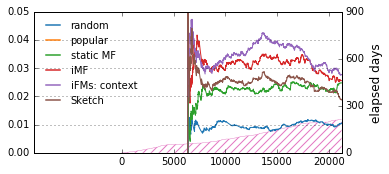

In [21]:
fig, ax = plt.subplots()

# axis #2: the distribution of a 'time' feature
ax2 = ax.twinx()
ax2.plot(exp_ML100k.data.dts, c=colors[12], lw=.4)
ax2.set_xlim((0, exp_ML100k.data.n_sample-1))
ax2.set_yticks([0, 300, 600, 900])
ax2.set_ylim([0, 900])
ax2.fill_between(np.arange(exp_ML100k.data.n_sample), np.array(exp_ML100k.data.dts), facecolor='none', edgecolor=colors[12], lw=0, hatch='///')
ax2.set_ylabel('elapsed days')
#ax2.get_yaxis().set_visible(False)

# axis #1: simple moving average of recall
x = np.arange(len(ML100k_rand_avgs))+exp_ML100k.data.n_batch_train+exp_ML100k.data.n_batch_test
ax.plot(x, ML100k_rand_avgs, c=colors[0], label='random')
ax.plot(x, ML100k_popular_avgs, c=colors[2], label='popular')
ax.plot(x, ML100k_static_avgs, c=colors[4], label='static MF')
ax.plot(x, ML100k_iMF_avgs, c=colors[6], label='iMF')
ax.plot(x, ML100k_iFMs_ctx_avgs, c=colors[8], label='iFMs: context')
# ax.plot(x, ML100k_sketch_avgs, c=colors[10], label='Sketch')
ax.plot(x, ML100k_static_FMs_avgs, c=colors[10], label='Sketch')
ax.set_xlim((-8500, exp_ML100k.data.n_sample-1))
ax.set_xticks([0, 5000, 10000, 15000, 20000])
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

# plot_setting(fig, ax, exp_ML100k.data.n_batch_train+exp_ML100k.data.n_batch_test-1)
fig.set_size_inches((5.5, 2.5))
ax.set_ylim([.0, .05])
ax.yaxis.grid(True)

leg = ax.legend(fontsize=10, loc='upper left', frameon=False)
for legobj in leg.legendHandles:
    legobj.set_linewidth(1.5)
    
plt.tight_layout()
#fig.savefig('../../paper/images/recsys-2016/ml-100k-recall.eps')

In [14]:
static5000_avgs, static5000_time = read_result('results/ML1M_static-MF_5000.txt') # reg=0.01, lr=0.003, epoch=9
iMF5000_avgs, iMF5000_time = read_result('results/ML1M_iMF_5000.txt') # reg=0.01, lr=0.003, epoch=9

rand5000_avgs, rand5000_time = read_result('results/ML1M_random_5000.txt') # epoch=1
popular5000_avgs, popular5000_time = read_result('results/ML1M_popular_5000.txt') # epoch=1

sketch5000_avgs, sketch5000_time = read_result('results/ML1M_sketch_5000.txt')

iFMs5000_avgs, iFMs5000_time = read_result('results/ML1M_iFMs_5000.txt')

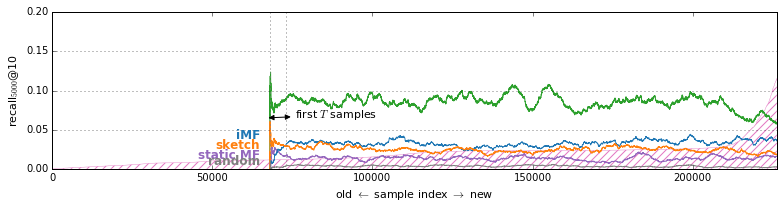

In [15]:
fig, ax = plt.subplots()

# axis #2: the distribution of a 'time' feature
ax2 = ax.twinx()
ax2.plot(exp.data.dts, c=colors[12], lw=.4)
ax2.set_xlim((0, exp.data.n_sample-1))
ax2.set_yticks([0, 600, 1200, 1800])
ax2.set_ylim([0, 1800])
ax2.fill_between(np.arange(exp.data.n_sample), np.array(exp.data.dts), facecolor='none', edgecolor=colors[12], lw=0, hatch='///')
# ax2.set_ylabel('elapsed days')
ax2.get_yaxis().set_visible(False)

# axis #1: simple moving average of recall
n_batch = exp.data.n_batch_train + exp.data.n_batch_test
x = np.arange(len(rand5000_avgs)) + n_batch
ax.plot(x, rand5000_avgs, c=colors[14], label='rand\n%.4f [s]' % rand5000_time)
ax.plot(x, popular5000_avgs, c=colors[4], label='popular\n%.4f [s]' % popular5000_time)
ax.plot(x, static5000_avgs, c=colors[8], label='static MF\n%.4f [s]' % static5000_time)
ax.plot(x, iMF5000_avgs, c=colors[0], lw=.8, label='iMF\n%.4f [s]' % iMF5000_time)
ax.plot(x, sketch5000_avgs, c=colors[2], label='sketch\n%.4f [s]' % sketch5000_time)
ax.text(65000, 0.0375, 'iMF', color=colors[0], fontsize=12, fontweight='bold', horizontalalignment='right')
ax.text(65000, 0.025, 'sketch', color=colors[2], fontsize=12, fontweight='bold', horizontalalignment='right')
ax.text(65000, 0.0125, 'static MF', color=colors[8], fontsize=12, fontweight='bold', horizontalalignment='right')
ax.text(65000, 0.005, 'random', color=colors[14], fontsize=12, fontweight='bold', horizontalalignment='right')
ax.set_xlim((0, exp.data.n_sample-1))
ax.annotate(r'first $T$ samples', xy=(n_batch-1000, 0.065), xytext=(n_batch+8000, 0.065), size=11, color='k',
            arrowprops=dict(color='k', lw=1., arrowstyle='<|-|>'))
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

plot_setting(fig, ax, exp.data.n_batch_train+exp.data.n_batch_test-1)
fig.set_size_inches((11, 3.))

#leg = ax.legend(fontsize=10, loc='upper left', frameon=False, framealpha=False)
#for legobj in leg.legendHandles:
#    legobj.set_linewidth(1.5)
    
plt.tight_layout()
# fig.savefig('../../paper/images/nas-2016/ml-1m-recall-box.eps')

In [20]:
# ML100k
recall_iFMs = [0.00471698113208, 0.00707547169811, 0.00801886792453, 0.00990566037736, 0.0127358490566, 0.0150943396226, 0.0193396226415, 0.0254716981132, 0.0297169811321, 0.0320754716981, 0.0334905660377, 0.0367924528302, 0.0372641509434, 0.0382075471698, 0.0400943396226, 0.0429245283019, 0.0466981132075, 0.0481132075472, 0.0509433962264, 0.0547169811321, 0.0570754716981, 0.0599056603774, 0.061320754717, 0.0627358490566, 0.063679245283, 0.0650943396226, 0.0674528301887, 0.0712264150943, 0.0731132075472, 0.0764150943396, 0.0792452830189, 0.0811320754717, 0.0830188679245, 0.086320754717, 0.0891509433962, 0.0905660377358, 0.0933962264151, 0.0938679245283, 0.0948113207547, 0.0962264150943]
recall_iMF = [0.00377358490566, 0.00943396226415, 0.0141509433962, 0.0169811320755, 0.0174528301887, 0.0193396226415, 0.0231132075472, 0.0268867924528, 0.0292452830189, 0.0325471698113, 0.0358490566038, 0.0372641509434, 0.0400943396226, 0.0415094339623, 0.0443396226415, 0.0462264150943, 0.047641509434, 0.0514150943396, 0.0542452830189, 0.0566037735849, 0.0580188679245, 0.0608490566038, 0.0627358490566, 0.0646226415094, 0.0660377358491, 0.0683962264151, 0.0702830188679, 0.0721698113208, 0.075, 0.077358490566, 0.0787735849057, 0.0792452830189, 0.0806603773585, 0.0820754716981, 0.0834905660377, 0.0858490566038, 0.0867924528302, 0.0882075471698, 0.0896226415094, 0.0919811320755]

# recall_popular = [0.0155660377358, 0.0306603773585, 0.0419811320755, 0.0485849056604, 0.0575471698113, 0.0674528301887, 0.0792452830189, 0.0900943396226, 0.100943396226, 0.11320754717, 0.120283018868, 0.124528301887, 0.131132075472, 0.137264150943, 0.141037735849, 0.146698113208, 0.15, 0.156603773585, 0.164150943396, 0.170754716981, 0.172169811321, 0.17641509434, 0.187264150943, 0.196698113208, 0.200471698113, 0.203301886792, 0.206132075472, 0.21179245283, 0.219339622642, 0.224528301887, 0.22641509434, 0.231132075472, 0.238679245283, 0.243396226415, 0.249528301887, 0.255188679245, 0.259905660377, 0.26179245283, 0.266509433962, 0.274528301887]
# recall_sketch = [0.000471698113208, 0.00283018867925, 0.00377358490566, 0.00424528301887, 0.00518867924528, 0.00660377358491, 0.00660377358491, 0.00707547169811, 0.00754716981132, 0.00849056603774, 0.00943396226415, 0.0108490566038, 0.0108490566038, 0.0117924528302, 0.0122641509434, 0.0127358490566, 0.013679245283, 0.0141509433962, 0.0150943396226, 0.0160377358491, 0.0160377358491, 0.0169811320755, 0.0183962264151, 0.0193396226415, 0.0198113207547, 0.0216981132075, 0.0235849056604, 0.0240566037736, 0.0259433962264, 0.0268867924528, 0.027358490566, 0.0287735849057, 0.0297169811321, 0.0311320754717, 0.0325471698113, 0.0334905660377, 0.036320754717, 0.038679245283, 0.0405660377358, 0.0429245283019]


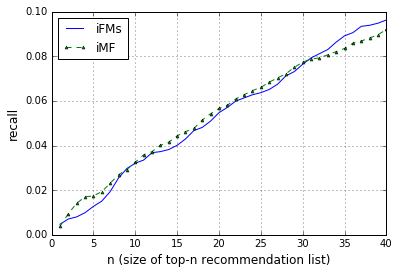

In [21]:
# compare recall@n in the batch evaluation step

fig, ax = plt.subplots()

x = np.arange(1, 41)
ax.plot(x, recall_iFMs, label='iFMs')
ax.plot(x, recall_iMF, label='iMF')
# ax.plot(x, recall_popular, label='popular')
# ax.plot(x, recall_sketch, label='sketch')

ax.set_xlabel("n (size of top-n recommendation list)")
ax.set_ylabel("recall")
ax.grid(True)
ax.legend(loc='upper left').get_frame().set_facecolor('white')
correctColors(ax, 'bgrk')
correctColors(ax.get_legend(), 'bgrk')
setAxLinesBW(ax, bw=False)
plt.show()

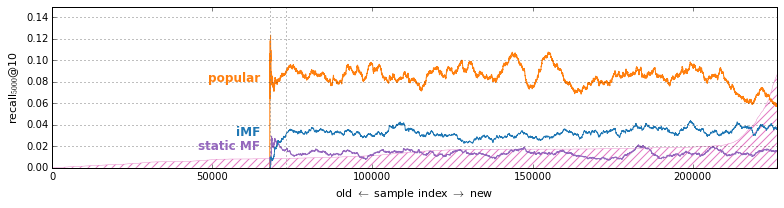

In [163]:
fig, ax = plt.subplots()

# axis #2: the distribution of a 'time' feature
ax2 = ax.twinx()
ax2.plot(exp.data.dts, c=colors[12], lw=.4)
ax2.set_xlim((0, exp.data.n_sample-1))
ax2.set_yticks([0, 600, 1200, 1800])
ax2.set_ylim([0, 1800])
ax2.fill_between(np.arange(exp.data.n_sample), np.array(exp.data.dts), facecolor='none', edgecolor=colors[12], lw=0, hatch='///')
# ax2.set_ylabel('elapsed days')
ax2.get_yaxis().set_visible(False)

# axis #1: simple moving average of recall
n_batch = exp.data.n_batch_train + exp.data.n_batch_test
x = np.arange(len(rand5000_avgs)) + n_batch
#ax.plot(x, iFMs5000_avgs, c=colors[6], label='iFMs\n%.4f [s]' % iFMs5000_time)
ax.plot(x, popular5000_avgs, c=colors[2], label='popular\n%.4f [s]' % popular5000_time)
ax.plot(x, static5000_avgs, c=colors[8], label='static MF\n%.4f [s]' % static5000_time)
ax.plot(x, iMF5000_avgs, c=colors[0], lw=.8, label='iMF\n%.4f [s]' % iMF5000_time)
#ax.plot(x, sketch5000_avgs, c=colors[2], label='sketch\n%.4f [s]' % sketch5000_time)
ax.text(65000, 0.03, 'iMF', color=colors[0], fontsize=12, fontweight='bold', horizontalalignment='right')
#ax.text(65000, 0.025, 'sketch', color=colors[2], fontsize=12, fontweight='bold', horizontalalignment='right')
ax.text(65000, 0.0175, 'static MF', color=colors[8], fontsize=12, fontweight='bold', horizontalalignment='right')
#ax.text(65000, 0.005, 'iFMs', color=colors[6], fontsize=12, fontweight='bold', horizontalalignment='right')
ax.text(65000, 0.08, 'popular', color=colors[2], fontsize=12, fontweight='bold', horizontalalignment='right')
ax.set_xlim((0, exp.data.n_sample-1))
#ax.annotate(r'first $T$ samples', xy=(n_batch-1000, 0.065), xytext=(n_batch+8000, 0.065), size=11, color='k',
#            arrowprops=dict(color='k', lw=1., arrowstyle='<|-|>'))
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

plot_setting(fig, ax, exp.data.n_batch_train+exp.data.n_batch_test-1)
ax.set_ylim([.0, .15])
fig.set_size_inches((11, 3.))

#leg = ax.legend(fontsize=10, loc='upper left', frameon=False, framealpha=False)
#for legobj in leg.legendHandles:
#    legobj.set_linewidth(1.5)
    
plt.tight_layout()
# fig.savefig('../../paper/images/nas-2016/ml-1m-recall-box.eps')

### Plot randomly sampled user/item activities

In [12]:
max_dt = exp.data.samples[-1]['dt']
max_dt

array([1038])

item-side

In [32]:
hist_toy = np.zeros(max_dt + 1)
hist_x = np.zeros(max_dt + 1)
hist_sw = np.zeros(max_dt + 1)

for i, d in enumerate(exp.data.samples):
    if d['title'] == 'Toy Story (1995)':
        hist_toy[d['dt']] += 1
    elif d['title'] == 'X-Men (2000)':
        hist_x[d['dt']] += 1
    elif d['title'] == 'Star Wars: Episode I - The Phantom Menace (1999)':
        hist_sw[d['dt']] += 1

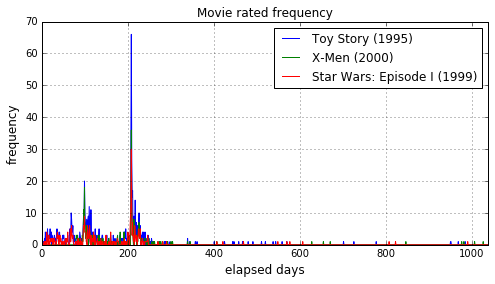

In [46]:
fig, ax = plt.subplots()

ax.set_xlim([0, max_dt + 1])

x = np.arange(max_dt + 1)

ax.plot(x, hist_toy, label='Toy Story (1995)')
ax.plot(x, hist_x, label='X-Men (2000)')
ax.plot(x, hist_sw, label='Star Wars: Episode I (1999)')

ax.set_title('Movie rated frequency')
ax.set_xlabel('elapsed days')
ax.set_ylabel('frequency')
ax.grid(True)
ax.legend(loc='upper right').get_frame().set_facecolor('white')

fig.set_size_inches((8, 4))
fig.patch.set_alpha(0.0)

plt.show()

user-side

In [65]:
hist_u1 = np.zeros(max_dt + 1)
hist_u2 = np.zeros(max_dt + 1)

for i, d in enumerate(exp.data.samples):
    if d['u_index'] == 2016:
        hist_u1[d['dt']] += 1
    elif d['u_index'] == 23:
        hist_u2[d['dt']] += 1

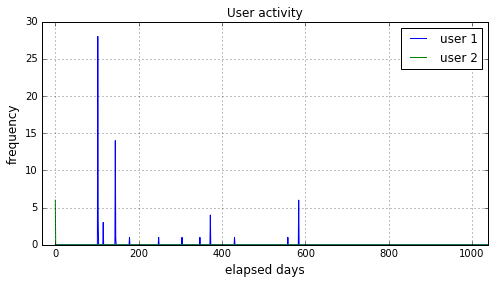

In [68]:
fig, ax = plt.subplots()

ax.set_xlim([-32, max_dt + 1])

x = np.arange(max_dt + 1)

ax.plot(x, hist_u1, label='user 1')
ax.plot(x, hist_u2, label='user 2')

ax.set_title('User activity')
ax.set_xlabel('elapsed days')3
ax.set_ylabel('frequency')
ax.grid(True)
ax.legend(loc='upper right').get_frame().set_facecolor('white')

fig.set_size_inches((8, 4))
fig.patch.set_alpha(0.0)

plt.show()